### Parametric Downconversion Simulation Example:

In [1]:
# This code will simulate the PDC Hamiltonian, plot the pump and 
# signal mode population, pump mode variance along momentum quadrature, 
# g2 of pump and signal modes, purity of the pump and the signal mode (after tracing out other modes),
# fourth and sixth order entanglement witnesses shown in the manuscript.
# Finally, you have the option to save data

#### Parameters for running the simulation:

In [2]:
import numpy as np
from pdc_functions import state_evolution

ALP_SQ = 1 * 10 ** (2)  # alpha square

# Threshold that determines the range of number states that are included
# in the input coherent state: |psi_in_pump> = \sum_{n=n1}^{n2} c_{n} |n>
# where n values are chosen such that |c_{n}|^{2} > PB_TH
PB_TH = 10 ** (-16)

# Total time of the evolution: (T_END chosen to observe the dynamics until the first 
# local maximum in signal-mode population: T_END=0.5 for ALP_SQ=100,
# T_END=0.3 for ALP_SQ=5*10^2, T_END=0.2 for ALP_SQ=10^3, T_END=0.06 for ALP_SQ=10^4)
T_END = 0.5

# Time step for the evolution: (optimized parameters: DELT_T=0.01 for ALP_SQ=10^2,
# DELT_T=0.001 for ALP_SQ=5*10^2, DELT_T=0.001 for ALP_SQ=10^3, DELT_T=0.0001 for alp_sq=10^4)
DELT_T = 0.001

output_data = state_evolution(ALP_SQ, T_END, DELT_T, PB_TH)

# Unpacking the data obtained from the above (for more details see below)
state_data=output_data[1::,1::] #state as a function of time is stored in rows for each time
t_arr=np.real(output_data[1::,0]) #times values of the state in each row
t_len=len(t_arr) #length of the time value array
num_arr=np.real(output_data[0,1:]).astype(int) #number of excitations stored along each column

### Here n1 and n2 accounts for truncation of the Hilbert space as it 
### appears in psi(t)=sum_{n=n1}^{n2} sum_{k=0}^{n} beta{n-k,k}|n-k>_{p} |k>_{s} |k>_{i} )
n1_val=np.real(num_arr[0]).astype(int) 
n2_val=np.real(num_arr[-1]).astype(int) 

#output_data has data arranged in the following manner:
###################################################################################################################
# Data is aranged such that we have states at different times arranged along different rows(besides the first row).
# The first row just contains the value of Np+NS corresponding to the state coefficients. 
# More specifically, the output data will appear as follows:
# ________________________________________________________________________________________________________________ 
# 0 |   n1      |    n1       |...|   n1     || n1+1       |...|   n1+1     ||...||n2(=n1+r)  |... |   n2       ||
#___|___________|_____________|___|__________||____________|___|____________||___||___________|____|____________||
# t1| b(n1,0,t1)| b(n1-1,1,t1)|...|b(0,n1,t1)||b(n1+1,0,t1)|...|b(0,n1+1,t1)||...||b(n2,0,t1) |... |b(0,n2+1,t1)||
# t2| b(n1,0,t2)| b(n1-1,1,t2)|...|b(0,n1,t2)||b(n1+1,0,t2)|...|b(0,n1+1,t2)||...||b(n2,0,t2) |... |b(0,n2+1,t2)||
# : |     :     |     :       |   |    :     ||    :       |   |     :      ||   ||    :      |    |     :      ||
# : |     :     |     :       |   |    :     ||    :       |   |     :      ||   ||    :      |    |     :      ||
# tn| b(n1,0,tn)| b(n1-1,1,tn)|...|b(0,n1,tn)||b(n1+1,0,tn)|   |b(n1,1,tn)  ||...|||b(n2,0,tn)| ...|b(0,n2+1,tn)||
#___|___________|_____________|___|__________||____________|___|____________||___||___________|____|____________||
# where b(n,k,t)=<n-k,k,k|psi(t)>. Note that b(n,k,t) = \beta_{n-k,k}(t) as
# defined in Eq. (7b), n1 and n2 accounts for truncation of the Hilbert space as it 
# appears in psi(t)=sum_{n=n1}^{n2} sum_{k=0}^{n} beta{n-k,k}|n-k>_{p} |k>_{s} |k>_{i} )

### 1. Computing populations, variance, autocorrelation function and $\langle a_{p}\rangle$:

In [3]:
from pdc_functions import moments

# Defining variables to store pump, signal and idler populations:
pump_pop=np.zeros(t_len) #Will store pump photons as a function of time in this array
sig_pop=np.zeros(t_len) #Will store signal photons as a function of time in this array
idl_pop=np.zeros(t_len) #Will store idler photons as a function of time in this array

pump_var_mntm=np.zeros(t_len) #Will store pump mode variance along the momentum quadrature

pump_g2 = np.zeros(t_len)
sig_g2= np.zeros(t_len)
sig_g2[0]=2

ap_vals = np.zeros(t_len)

for tt_ind in range(0,t_len,1):
    state=state_data[tt_ind,:] #state at time tt

    pump_pop[tt_ind]=moments(1,1,0,0,0,0,state,n1_val,n2_val) #computing number of pump photons
    sig_pop[tt_ind]=moments(0,0,1,1,0,0,state,n1_val,n2_val) #computing number of signal photons
    idl_pop[tt_ind]=moments(0,0,0,0,1,1,state,n1_val,n2_val) #computing number of signal photons
    
    temp1=moments(2,0,0,0,0,0,state,n1_val,n2_val)-moments(1,0,0,0,0,0,state,n1_val,n2_val)**2
    temp2=moments(1,1,0,0,0,0,state,n1_val,n2_val) -moments(1,0,0,0,0,0,state,n1_val,n2_val)**2
    
    ## See Eq. C11 in the Appendix
    pump_var_mntm[tt_ind]=-temp1+temp2+0.5

    pump_g2[tt_ind]=(moments(2,2,0,0,0,0,state,n1_val,n2_val)/(moments(1,1,0,0,0,0,state,n1_val,n2_val)**2))
    
    if tt_ind>0:
        sig_g2[tt_ind]=(moments(0,0,2,2,0,0,state,n1_val,n2_val)/(moments(0,0,1,1,0,0,state,n1_val,n2_val)**2))

    ap_vals[tt_ind]= moments(1,0,0,0,0,0,state,n1_val,n2_val) #computing <ap>


#### Plotting populations, variance, $g^{(2)}$ and $\langle a_{p}\rangle$:

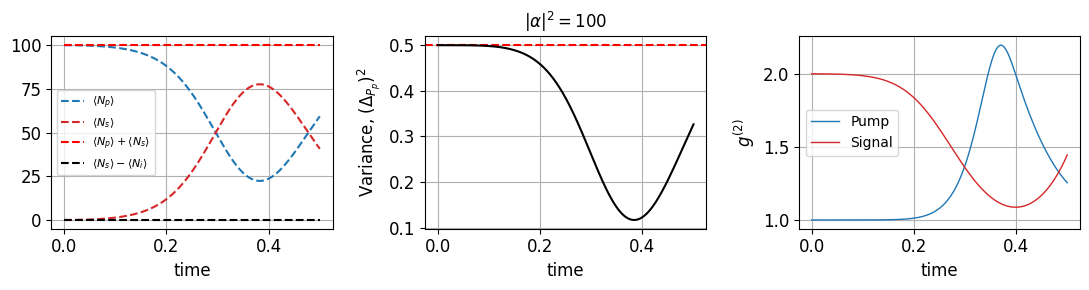

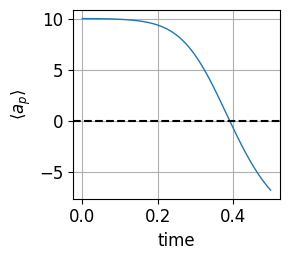

In [4]:
### Plotting mean pump and signal photons
import matplotlib.pyplot as plt
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(11,3))
#fig = plt.figure(figsize=(5,4))
ax1.plot(t_arr,pump_pop,'--',color='tab:blue',label=r'$\langle N_{p}\rangle$')
ax1.plot(t_arr,sig_pop,'--',color='tab:red',label=r'$\langle N_{s}\rangle$')
ax1.plot(t_arr,pump_pop+sig_pop,'--',color='red',label=r'$\langle N_{p}\rangle+\langle N_{s}\rangle$')
ax1.plot(t_arr,sig_pop-idl_pop,'--',color='black',label=r'$\langle N_{s}\rangle-\langle N_{i}\rangle$')
ax1.grid(True)
ax1.legend(prop={'size':8},ncol=1)
ax1.set_xlabel(r"time",size=12)
ax1.tick_params(labelsize=12)

ax2.axhline(y=0.5,ls='dashed',color='red')
ax2.plot(t_arr,pump_var_mntm,'-',color='black')
ax2.grid(True)
ax2.set_title(fr"$|\alpha|^{2}={ALP_SQ}$", size=12)
ax2.set_xlabel(r"time",size=12)
ax2.set_ylabel(r"Variance, $(\Delta_{P_{p}})^{2}$",size=12)
ax2.tick_params(labelsize=12)

ax3.plot(t_arr,pump_g2,'-',lw=1,color='tab:blue',label=r'Pump')
ax3.plot(t_arr,sig_g2,'-',lw=1,color='tab:red',label=r'Signal')
ax3.grid(True)
ll=ax3.legend(prop={'size':10},ncol=1)
ax3.set_ylabel(r"$g^{(2)}$",size=12)
ax3.set_xlabel(r"time",size=12)
plt.tick_params(labelsize=12)

plt.tight_layout()

fig = plt.figure(figsize=(3,2.7))
plt.plot(t_arr,ap_vals,'-',lw=1,color='tab:blue')
plt.axhline(y=0,ls='dashed',color='black')
plt.grid(True)
plt.ylabel(r"$\langle a_{p} \rangle $",size=12)
plt.xlabel(r"time",size=12)
plt.tick_params(labelsize=12)
plt.tight_layout()

### 2. Photon number statistics:

In [5]:
from pdc_functions import pump_marg_prob, signal_marg_prob

pump_marg_dist1=np.zeros(n2_val+1)
pump_marg_dist2=np.zeros(n2_val+1)
pump_marg_dist3=np.zeros(n2_val+1)
pump_marg_dist4=np.zeros(n2_val+1)

sig_marg_dist1=np.zeros(n2_val+1)
sig_marg_dist2=np.zeros(n2_val+1)
sig_marg_dist3=np.zeros(n2_val+1)
sig_marg_dist4=np.zeros(n2_val+1)

time_ind1=100
phi1=np.real(state_data[time_ind1,:])

time_ind2=250
phi2=np.real(state_data[time_ind2,:])

time_ind3=300
phi3=np.real(state_data[time_ind3,:])

time_ind4=390
phi4=np.real(state_data[time_ind4,:])

for num_pump in range(0,n2_val+1,1):
    pump_marg_dist1[num_pump]=pump_marg_prob(phi1,num_pump,n1_val,n2_val)
    pump_marg_dist2[num_pump]=pump_marg_prob(phi2,num_pump,n1_val,n2_val)
    pump_marg_dist3[num_pump]=pump_marg_prob(phi3,num_pump,n1_val,n2_val)
    pump_marg_dist4[num_pump]=pump_marg_prob(phi4,num_pump,n1_val,n2_val)

    sig_marg_dist1[num_pump]=signal_marg_prob(phi1,num_pump,n1_val,n2_val)
    sig_marg_dist2[num_pump]=signal_marg_prob(phi2,num_pump,n1_val,n2_val)
    sig_marg_dist3[num_pump]=signal_marg_prob(phi3,num_pump,n1_val,n2_val)
    sig_marg_dist4[num_pump]=signal_marg_prob(phi4,num_pump,n1_val,n2_val)


#### Plotting photon number statistics:

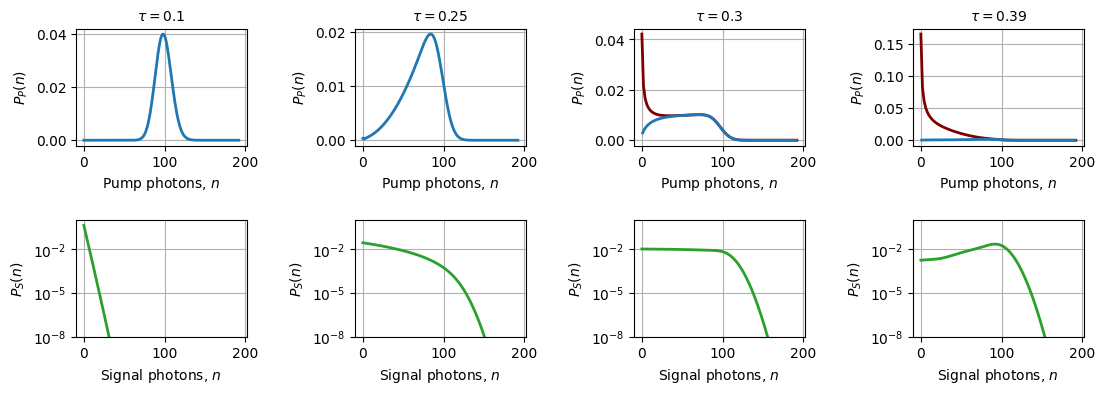

In [6]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig=plt.figure(figsize=(13,4))
gs = GridSpec(5,11)
ax_marg_p1 = fig.add_subplot(gs[0:2,0:2])
ax_marg_s1 = fig.add_subplot(gs[3:5,0:2])

ax_marg_p2 = fig.add_subplot(gs[0:2,3:5])
ax_marg_s2 = fig.add_subplot(gs[3:5,3:5])

ax_marg_p3 = fig.add_subplot(gs[0:2,6:8])
ax_marg_s3 = fig.add_subplot(gs[3:5,6:8])

ax_marg_p4 = fig.add_subplot(gs[0:2,9:11])
ax_marg_s4 = fig.add_subplot(gs[3:5,9:11])

num_phot_range=np.arange(0,n2_val+1,1)

##Plot1 
#########################################################################
ax_marg_p1.plot(num_phot_range,pump_marg_dist1,color='tab:blue',lw='2')
ax_marg_p1.tick_params(labelsize=10)
ax_marg_p1.set_title(r'$\tau= %g$'%(t_arr[time_ind1]),size=10)
ax_marg_p1.set_ylabel('$P_{P}(n)$',size=10) # Set labels on joint
ax_marg_p1.set_xlabel('Pump photons, $n$',size=10) # Set labels on joint
ax_marg_p1.grid(True)

ax_marg_s1.semilogy(num_phot_range,sig_marg_dist1,color='tab:green',lw='2')
ax_marg_s1.set_ylim([10**-8,10**0])
ax_marg_s1.set_ylabel('$P_{S}(n)$',size=10) # Set labels on joint
ax_marg_s1.set_xlabel('Signal photons, $n$',size=10)# Set labels on joint
ax_marg_s1.grid(True)
ax_marg_s1.tick_params(labelsize=10)

##Plot2
###########################################################################
#########################################################################
ax_marg_p2.plot(num_phot_range,pump_marg_dist2,color='tab:blue',lw='2')
ax_marg_p2.tick_params(labelsize=10)
ax_marg_p2.set_title(r'$\tau= %g$'%(t_arr[time_ind2]),size=10)
ax_marg_p2.set_ylabel('$P_{P}(n)$',size=10) # Set labels on joint
ax_marg_p2.set_xlabel('Pump photons, $n$',size=10) # Set labels on joint
ax_marg_p2.grid(True)

ax_marg_s2.semilogy(num_phot_range,sig_marg_dist2,color='tab:green',lw='2')
ax_marg_s2.set_ylim([10**-8,10**0])
ax_marg_s2.set_ylabel('$P_{S}(n)$',size=10) # Set labels on joint
ax_marg_s2.set_xlabel('Signal photons, $n$',size=10)# Set labels on joint
ax_marg_s2.grid(True)
ax_marg_s2.tick_params(labelsize=10)

##Plot3
###########################################################################
#########################################################################
ax_marg_p3.plot(num_phot_range[0::2],pump_marg_dist3[0::2],'-',color='maroon',lw='2')
ax_marg_p3.plot(num_phot_range[1::2],pump_marg_dist3[1::2],'-',color='tab:blue',lw='2')
ax_marg_p3.tick_params(labelsize=10)
ax_marg_p3.set_title(r'$\tau= %g$'%(t_arr[time_ind3]),size=10)
ax_marg_p3.set_ylabel('$P_{P}(n)$',size=10) # Set labels on joint
ax_marg_p3.set_xlabel('Pump photons, $n$',size=10) # Set labels on joint
ax_marg_p3.grid(True)

ax_marg_s3.semilogy(num_phot_range,sig_marg_dist3,color='tab:green',lw='2')
ax_marg_s3.set_ylim([10**-8,10**0])
ax_marg_s3.set_ylabel('$P_{S}(n)$',size=10) # Set labels on joint
ax_marg_s3.set_xlabel('Signal photons, $n$',size=10)# Set labels on joint
ax_marg_s3.grid(True)
ax_marg_s3.tick_params(labelsize=10)

##Plot4
###########################################################################
#########################################################################
ax_marg_p4.plot(num_phot_range[0::2],pump_marg_dist4[0::2],'-',color='maroon',lw='2')
ax_marg_p4.plot(num_phot_range[1::2],pump_marg_dist4[1::2],'-',color='tab:blue',lw='2')
ax_marg_p4.tick_params(labelsize=10)
ax_marg_p4.set_title(r'$\tau= %g$'%(t_arr[time_ind4]),size=10)
ax_marg_p4.set_ylabel('$P_{P}(n)$',size=10) # Set labels on joint
ax_marg_p4.set_xlabel('Pump photons, $n$',size=10) # Set labels on joint
ax_marg_p4.grid(True)

ax_marg_s4.semilogy(num_phot_range,sig_marg_dist4,color='tab:green',lw='2')
ax_marg_s4.set_ylim([10**-8,10**0])
ax_marg_s4.set_ylabel('$P_{S}(n)$',size=10) # Set labels on joint
ax_marg_s4.set_xlabel('Signal photons, $n$',size=10)# Set labels on joint
ax_marg_s4.grid(True)
ax_marg_s4.tick_params(labelsize=10)


### 3. Entanglement:

In [7]:
from pdc_functions import pump_mat_purity, sig_mat_purity, witness_fourth_order, witness_sixth_order

pump_purity=np.zeros(t_len)
sig_purity=np.zeros(t_len)

fourth_ord_wit=np.zeros(t_len)
sixth_ord_wit=np.zeros(t_len)

for time_ind in range(0,t_len):
    phi=np.real(state_data[time_ind,:])
    
    #Purity of pump and signal modes
    pump_purity[time_ind]=pump_mat_purity(phi,n1_val,n2_val)
    sig_purity[time_ind]=sig_mat_purity(phi,n1_val,n2_val)

    # Fourth and sixth order witnesses of entanglement
    fourth_ord_wit[time_ind]=(1/ALP_SQ**2)*witness_fourth_order(phi,n1_val,n2_val)
    sixth_ord_wit[time_ind]=(1/ALP_SQ**3)*witness_sixth_order(phi,n1_val,n2_val)
    

#### 3a. Purity plot:

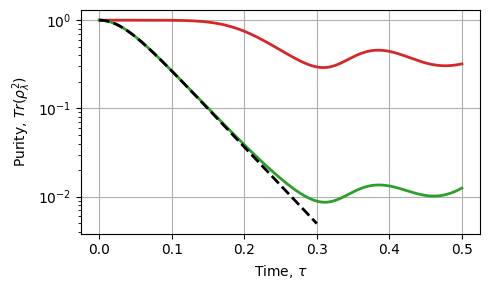

In [8]:
import matplotlib.pyplot as plt

# Computing entropy of the signal mode in the parametric approximation:
ent_paramet=np.zeros(len(t_arr))
ent_paramet=1/np.cosh(2*np.sqrt(ALP_SQ)*t_arr)
#########################################################################

fig = plt.figure(figsize=(5,3))
plt.semilogy(t_arr,pump_purity,'-',lw='2',color='tab:red',label=r'Pump')
plt.semilogy(t_arr,sig_purity,'-',lw='2',color='tab:green',label=r'Signal')

temp_ind=-200
plt.semilogy(t_arr[0:temp_ind],ent_paramet[0:temp_ind],'--',lw='2',color='black')

plt.ylabel(r"Purity, $Tr(\rho_{\lambda}^{2})$",size=10)
plt.xlabel(r"Time, $\tau$",size=10)
plt.tick_params(labelsize=10)
plt.tight_layout()
plt.grid(True)
plt.show()

#### 3b. Witness plots:

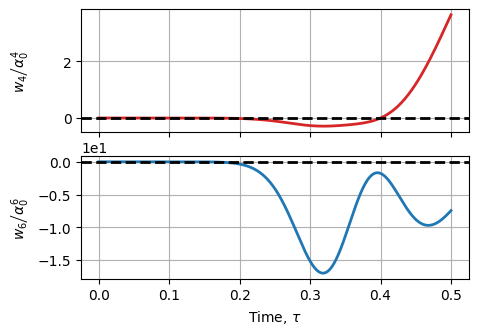

In [9]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(2,sharex=True,figsize=(5,3.5))
axs[0].plot(t_arr,fourth_ord_wit,'-',lw=2,color='tab:red')
axs[0].axhline(y=0,color='black',ls='dashed',lw=2)
axs[0].ticklabel_format(axis='y',style='sci',scilimits=(-1,-4))
axs[0].yaxis.offsetText.set_fontsize(20)
axs[0].grid(True)
axs[0].tick_params(labelsize=10)
axs[0].set_ylabel(r'$w_{4}\left/ \alpha_{0}^{4} \right.$',size=10)

axs[1].plot(t_arr,sixth_ord_wit,'-',lw=2,color='tab:blue')
axs[1].axhline(y=0,color='black',ls='dashed',lw=2)
axs[1].ticklabel_format(axis='y',style='sci',scilimits=(-1,-4))
axs[1].yaxis.offsetText.set_fontsize(10)
axs[1].grid(True)
axs[1].tick_params(labelsize=10)        
axs[1].set_ylabel(r"$w_{6} \left/ \alpha_{0}^{6} \right.$",size=10)
axs[1].set_xlabel(r"Time, $\tau$",size=10)
fig.align_ylabels(axs[:])   

#### Exporting data (run only if you want to save data):

In [10]:
### For saving state data:
#np.savez_compressed(f"PDC_states_{ALP_SQ}pump_photons_{IN_ARR}part", output_data)

### For saving state data associated with various quantities:
#np.savez(f"PDC_{ALP_SQ}pump_photons_full_numerical_simulation",time=t_arr,\
#         pump_population=pump_pop,sig_population=sig_pop,pump_variance_momentum=pump_var_mntm,\
#            pump_g2=pump_g2,sig_g2=sig_g2)